In [67]:
###########################################################################
# _  _  _  _  _                       _                                            
#    (_)(_)(_)(_)(_)                     (_)                                          
#          (_) _         _  _       _  _ (_) _  _  _       _  _  _                       
#          (_)(_)       (_)(_)_  _ (_)(_)(_)(_)(_)(_)_  _ (_)(_)(_) _    
#          (_)(_)       (_)  (_)(_)      (_)        (_)(_)         (_)    
#          (_)(_)       (_)  (_)         (_)        (_)(_)         (_)         
#          (_)(_)_  _  _(_)_ (_)         (_) _  _  _(_)(_) _  _  _ (_)     
#          (_)  (_)(_)(_) (_)(_)         (_)(_)(_)(_)     (_)(_)(_)                                              
#                                ____   _   _ 
#                         /\    |  _ \ | | | |
#                        /  \   | |_) )| |_| |
#                       / /\ \  |  __/ |  _  |
#                      / /__\ \ | |    | | | |
#                     /________\|_|    |_| |_|
#                                                   

###########################################################################                                                                                                                     

#  /\/\/\                            /  \
# | \  / |                         /      \
# |  \/  |                       /          \
# |  /\  |----------------------|     /\     |
# | /  \ |                      |    /  \    |
# |/    \|                      |   /    \   |
# |\    /|                      |  | (  ) |  |
# | \  / |                      |  | (  ) |  |
# |  \/  |                 /\   |  |      |  |   /\
# |  /\  |                /  \  |  |      |  |  /  \
# | /  \ |               |----| |  |      |  | |----|
# |/    \|---------------|    | | /|   .  |\ | |    |
# |\    /|               |    | /  |   .  |  \ |    |
# | \  / |               |    /    |   .  |    \    |
# |  \/  |               |  /      |   .  |      \  |
# |  /\  |---------------|/        |   .  |        \|
# | /  \ |              /          |   .  |         \
# |/    \|             (           |      |           )
# |/\/\/\|               |    | |--|      |--| |    |
# ------------------------/  \-----/  \/  \-----/  \--------
#                         \\//     \\//\\//     \\//
#                          \/       \/  \/       \/ ⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
#      ___                                                           
#     (   )                                                          
#      | |.-.              .--.   ___ .-.     .--.  ___  ___  .-..   
#      | /   \            /    \ (   )   \   /    \(   )(   )/    \  
#      |  .-. | .------. ;  ,-. ' | ' .-. ; |  .-. ;| |  | |' .-,  ; 
#      | |  | |(________)| |  | | |  / (___)| |  | || |  | || |  . | 
#      | |  | |          | |  | | | |       | |  | || |  | || |  | | 
#      | |  | |          | |  | | | |       | |  | || |  | || |  | | 
#      | '  | |          | '  | | | |       | '  | || |  ; '| |  ' | 
#      ' `-' ;           '  `-' | | |       '  `-' /' `-'  /| `-'  ' 
#       `.__.             `.__. |(___)       `.__.'  '.__.' | \__.'  
#                         ( `-' ;                           | |      
#                          `.__.                           (___) 


In [69]:
"""
Author: Marco Virgilio
Date: 2024-Dec-06
Email: marcovirgilio88@hotmail.it
Description: The code is a one-dimensional solver designed to predict 
the impact of pressure gradient histories (dp/dx = f(x)) on turbulent 
boundary layers in non-equilibrium, focusing on integral parameters 
such as momentum and displacement thicknesses, skin friction coefficient, 
and the Clauser pressure-gradient parameter along with its integral form. 
This solver has been calibrated against experimental data from turbulent 
boundary layers under pressure gradients generated by a NACA0012 airfoil 
at various angles of attack (-8°, -4°, 0°, 4°, 8°) with an inflow velocity
of U_inf = 20 m/s.
"""

'\nAuthor: Marco Virgilio\nDate: 2024-Dec-06\nEmail: marcovirgilio88@hotmail.it\nDescription: The code is a one-dimensional solver designed to predict \nthe impact of pressure gradient histories (dp/dx = f(x)) on turbulent \nboundary layers in non-equilibrium, focusing on integral parameters \nsuch as momentum and displacement thicknesses, skin friction coefficient, \nand the Clauser pressure-gradient parameter along with its integral form. \nThis solver has been calibrated against experimental data from turbulent \nboundary layers under pressure gradients generated by a NACA0012 airfoil \nat various angles of attack (-8°, -4°, 0°, 4°, 8°) with an inflow velocity\nof U_inf = 20 m/s.\n'

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pickle

from scipy.interpolate import griddata

In [73]:
# Function to compute the pressure gradients history effects
def mov_upstr_mean(x, N, mode, k):
    """
    Compute a moving upstream mean for an array x.
    Parameters:
    x : array-like
        Input array.
    N : int
        Length parameter for the computation.
    mode : str
        Weighting mode ('gaussian' or 'linear').
    k : float
        Sigmoid sharpness parameter.
    Returns:
    result : ndarray
        The resulting array of moving upstream means.
    """
    x      = np.array(x)  # Ensure input is a NumPy array
    dx     = np.abs(np.gradient(x))  # Compute gradients
    result = np.zeros_like(x)  # Initialize the result array

    if N == len(x):
        for i in range(1, N + 1):
            # Define Gaussian parameters
            a = 1  # Amplitude
            b = i  # Mean (peak at the end of the array)
            c = 0.5  # Standard deviation

            indices = np.arange(1, i + 1)

            # Compute weights based on the selected mode
            if mode == 'gaussian':
                weights_s = a * np.exp(-((indices - b) ** 2) / (2 * c ** 2))
            elif mode == 'linear':
                weights_s = indices
            else:
                raise ValueError("Invalid mode. Choose 'gaussian' or 'linear'.")

            # Normalize the weights
            s = weights_s / np.max(weights_s)
            t = dx[:i] / np.max(dx[:i])

            # Compute modified sigmoid weights
            sigmoid_s = 1 / (1 + np.exp(-k * (s - 0.5)))
            sigmoid_t = 1 / (1 + np.exp(-k * (t - 0.5)))
            weights   = sigmoid_s * sigmoid_t

            # Apply weights and compute weighted mean
            weighted_x    = x[:i] * weights
            result[i - 1] = np.mean(weighted_x)

    else:
        for i in range(1, len(x)):
            # Compute the mean of the interval x(1:i)
            result[i] = np.mean(x[:i + 1])

    return result

In [75]:
def bernoulli_vel(dpdx,Dx,u0,rho):
    dp = dpdx*Dx[0]
    Dp = np.zeros(len(dp))
    for i in range(len(dp)):
        Dp[i] = np.sum(dp[0:i+1])
    u_inf = np.sqrt(u0**2-2*Dp/rho)
    return u_inf

In [77]:
def PGTurbo_solver(Input, loaded_arrays, x, Ddeltastar_zpgDx, dCf_zpg_dx, dpdx, u_inf, weight, rho):
    Output                           = {}
    n                                = len(x)-1
    Output['theta']                  = np.zeros(n)
    Output['tau']                    = np.zeros(n)
    Output['deltas']                 = np.zeros(n)
    Output['Cf']                     = np.zeros(n)
    Output['beta']                   = np.zeros(n)
    Output['betaTilde']              = np.zeros(n)
    Ddelta_star_solverDx             = np.zeros(len(x)-1) 
    dCfdx_solver                     = np.zeros(len(x)-1) 
    Output['theta'][0]               = Input['theta']
    Output['tau'][0]                 = Input['tau']
    Output['deltas'][0]              = Input['deltas']
    Output['Cf'][0]                  = Input['Cf']
    Output['beta'][0]                = Input['beta']
    Output['betaTilde'][0]           = Input['betaTilde']   
    Dx                               = np.diff(x)
    for i in range(len(x)-2):
        C4                           = griddata((loaded_arrays[0], loaded_arrays[1]), loaded_arrays[2], (Output['beta'][i], Output['betaTilde'][i]), method = 'linear', fill_value=0)
        C5                           = griddata((loaded_arrays[0], loaded_arrays[1]), loaded_arrays[3], (Output['beta'][i], Output['betaTilde'][i]), method = 'linear', fill_value=0)
        Ddelta_star_solverDx[i]      = Ddeltastar_zpgDx[i]+C4*Output['deltas'][i]
        dCfdx_solver[i]              = dCf_zpg_dx[i]      +C5*Output['Cf'][i]
        # dCfdx_solver[i]              = dCf_zpg_dx[i]      +C5*Input['Cfzpg'][i]
        # Ddelta_star_solverDx[i]      = Ddeltastar_zpgDx[i]+C4*Input['dzpg'][i]
        A                            = 1 - 2 * dpdx[i+1] * Dx[0] / rho / (u_inf[i+1]**2)
        B                            = dpdx[i+1] * Dx[0] / rho / (u_inf[i+1]**2)
        Matrix                       = np.array([
                              [A,    -B,     -Dx[0]/2],
                              [0.0,   1.0,     0.0   ],
                              [0.0,   0.0,     1.0   ]
        ])
        b                            = np.array([Output['theta'][i], Output['deltas'][i] + Ddelta_star_solverDx[i]*Dx[0], Output['Cf'][i] + dCfdx_solver[i]*Dx[i]])
        a                            = np.linalg.solve(Matrix, b)
        Output['theta'][i+1]         = a[0]
        Output['deltas'][i+1]        = a[1]
        Output['Cf'][i+1]            = a[2]
        Output['tau'][i+1]           = Output['Cf'][i+1]*0.5*rho*u_inf[i+1]**2
        # Check and replace NaN values
        if np.isnan(Output['theta'][i+1]):
            Output['theta'][i+1]     = Output['theta'][i]
        
        if np.isnan(Output['deltas'][i+1]):
            Output['deltas'][i+1]    = Output['deltas'][i]
        
        if np.isnan(Output['Cf'][i+1]):
            Output['Cf'][i+1]        = Output['Cf'][i]
        
        if np.isnan(Output['tau'][i+1]):
            Output['tau'][i+1]       = Output['tau'][i]
        Output['beta'][i+1]          = dpdx[i+1]*Output['deltas'][i+1]/Output['tau'][i+1]
        btilde                       = mov_upstr_mean(Output['beta'][:i+2], len(Output['beta'][:i+2]), weight, loaded_arrays[4])
        Output['betaTilde'][i+1]     = btilde[-1]
        if np.isnan(Output['beta'][i+1]):
            Output['beta'][i+1]      = Output['beta'][i]
        if np.isnan(Output['betaTilde'][i+1]):
            Output['betaTilde'][i+1] = Output['betaTilde'][i]
    return Output

In [79]:
weight             = 'linear'
model              = 'lag'
scheme             = 'implicit'

In [81]:
Input              = {}
#Numbers of point in the 1-D mesh
N                  = 1000
# Free-stream velocity
u0                 = 20           # ms-1
# Kinematic viscosity
ni_                = 1.516e-5     # m2s-1
# Start and End of the simulation
Xstart             = 4.92         # m
Xend               = 9.48         # m
# Reynolds number at x0
Re_x0              = Xstart*u0/ni_
# momentum thickness at the start of the simulation compure with ZPG correlation
theta0             = Xstart*0.037/(Re_x0**(1/5))
# Re with theta at x0
Re_theta0          = theta0*u0/ni_
# Values to compute the Skin friction coefficient at the start, ZPG case
kappa              = 0.384
C                  = 2.127
D0                 = 220
D1                 = 0
Cf0                = 2*((1/kappa)*np.log(Re_theta0)+C+D0*np.log(Re_theta0)/Re_theta0+D1/Re_theta0)**(-2)
# reference length scale displacement thickness at 0  (here = ZPG)
C1                 = 7.135
E1                 = -19.12
U_infplus0         = np.sqrt(2/Cf0)
H_0                = 1/(1-(C1/U_infplus0))+E1/Re_theta0
delta_star0        = H_0*theta0

In [83]:
#Dimensionless parameters
rho                = 1
x                  = np.linspace(Xstart,Xend,N)/delta_star0
Dx                 = np.diff(x)  
ni                 = ni_/(u0*delta_star0)

In [85]:
# Boundary conditions of the solver: dpdx=f(x) (dimensionless)
# initialization
dpdx               = np.zeros(N)*(delta_star0/(rho*u0**2))
# choose which part of the dpdpx is =!0
N1                 = 0
N2                 = N
# frequency and amplitude of the sinusoid
freq               = -8
Ampl               = 20
pi                 = math.pi
# Boundary Condition to the solver at the wall
dpdx[N1:N2]        = Ampl*np.sin(np.linspace(-freq*pi,freq*pi,N2-N1))*(delta_star0/(rho*u0**2))

In [87]:
# load data from calibration
with open('arrays.pkl', 'rb') as f:
    loaded_arrays  = pickle.load(f)

In [89]:
# Free-stream velocity = f(x)
u_inf              = bernoulli_vel(dpdx*(rho*u0**2)/delta_star0,Dx*delta_star0,u0,rho)/u0
Re_x               = x[:-1]*u_inf[:-1]/ni
theta_zpg          = x[:-1]*0.037/(Re_x**(1/5))
Re_theta           = theta_zpg*u_inf[:-1]/ni
Cf_zpg             = 2*((1/kappa)*np.log(Re_theta)+C+D0*np.log(Re_theta)+D1/Re_theta)**(-2)
dCf_zpg_dx         = np.gradient(Cf_zpg,x[:-1])
U_infplus          = np.sqrt(2/Cf_zpg)
H_zpg              = (1/(1-(C1/U_infplus)))+E1/Re_theta
deltastar_zpg      = H_zpg*theta_zpg
Ddeltastar_zpgDx   = np.gradient(deltastar_zpg,x[:-1])

In [91]:
# Initial conditions of the solver
Input['Cf']        = Cf0  
Input['beta']      = 0
Input['betaTilde'] = 0
Input['theta']     = theta0/delta_star0
Input['tau']       = Input['Cf']*0.5*rho*u_inf[0]**2
Input['deltas']    = deltastar_zpg[0]
Input['Cfzpg']     = Cf_zpg
Input['dzpg']      = deltastar_zpg 

In [93]:
Output             = PGTurbo_solver(Input, loaded_arrays, x, Ddeltastar_zpgDx, dCf_zpg_dx, dpdx, u_inf, weight, rho)

In [95]:
theta_solver       = Output['theta']
tau_w_solver       = Output['tau']
delta_star_solver  = Output['deltas']
Cf_solver          = Output['Cf']
beta_solver        = Output['beta']
BetaOverbar_solver = Output['betaTilde']

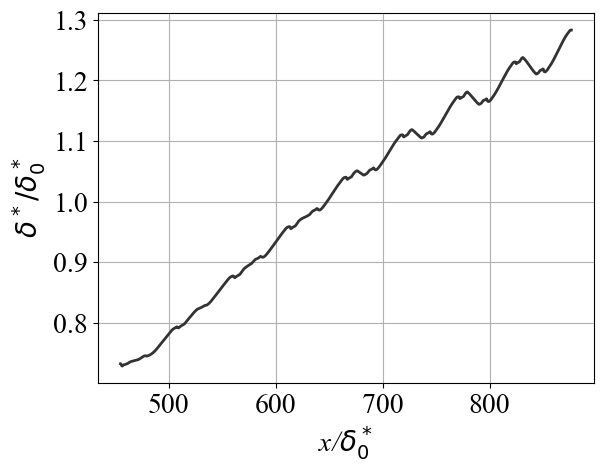

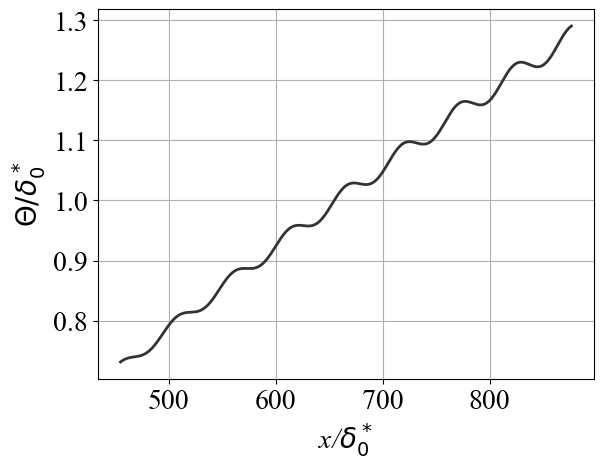

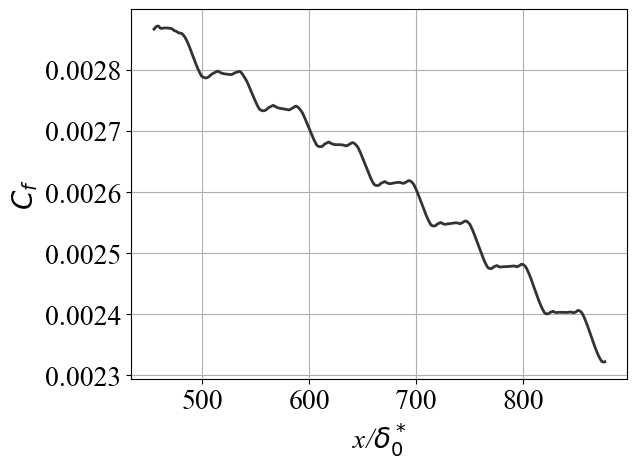

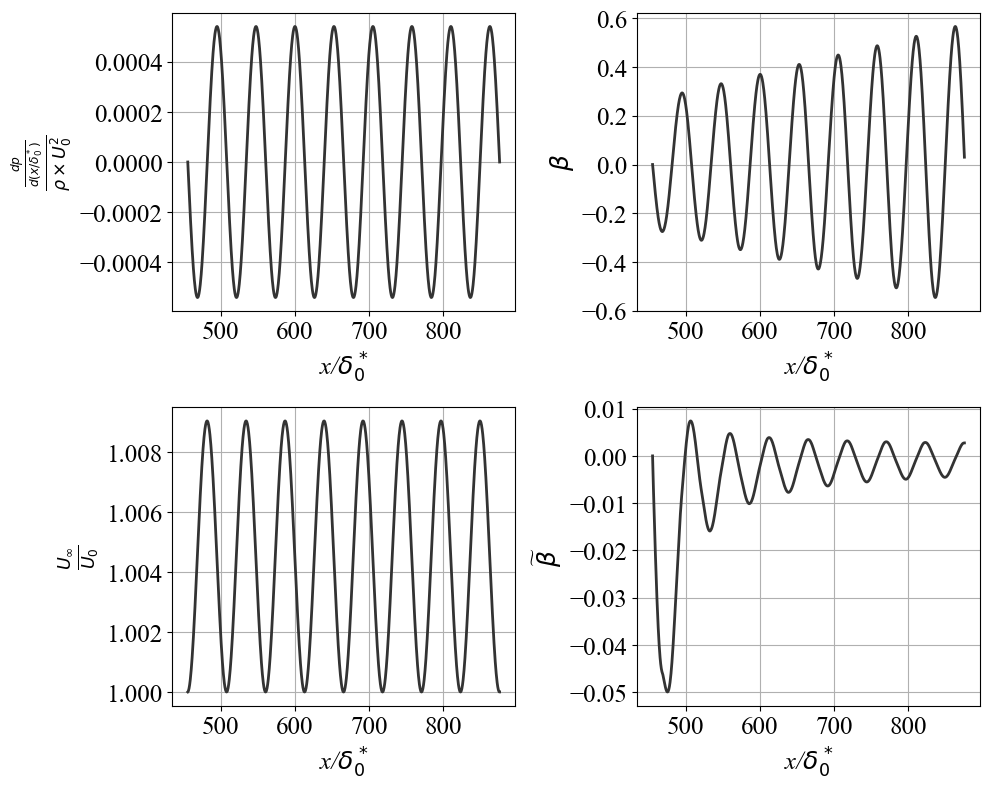

In [97]:
# Set general font properties (if desired)
gray = 0.2
color = (gray, gray, gray)

plt.rc('font', family='Times New Roman')
plt.rc('text', usetex=False)  # Set to True if you have a LaTeX installation and want to use full LaTeX.

# Figure 1
plt.figure(1)
plt.plot(x[:-1], delta_star_solver, '-', color=color, markersize=8, linewidth=2)
plt.xlabel(r'x/$\delta_0^*$', fontsize=20, style='italic')
plt.ylabel(r'$\delta^*/\delta_0^*$', fontsize=20, style='italic')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True)  # or omit if you prefer no grid

# Figure 2
plt.figure(2)
plt.plot(x[:-1], theta_solver, '-', color=color, markersize=8, linewidth=2)
# plt.plot(x[0, :-1], theta, ':', color=color, markersize=8, linewidth=2)
plt.xlabel(r'x/$\delta_0^*$', fontsize=20, style='italic')
plt.ylabel(r'$\Theta/\delta_0^*$', fontsize=20, style='italic')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True)

# Figure 3
plt.figure(3)
plt.plot(x[:-1], Cf_solver, '-', color=color, markersize=8, linewidth=2)
plt.xlabel(r'x/$\delta_0^*$', fontsize=20, style='italic')
plt.ylabel(r'$C_f$', fontsize=20, style='italic')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True)

# Figure 4 with subplots
plt.figure(4, figsize=(10, 8))

# Subplot (2,2,1)
plt.subplot(2, 2, 1)
plt.plot(x[:], dpdx, '-', color=color, markersize=8, linewidth=2)
plt.xlabel(r'x/$\delta_0^*$', fontsize=18, style='italic')
plt.ylabel(r'$\frac{\frac{dp}{d(x/\delta^*_0)}}{\rho \times U_{0}^2}$', fontsize=18, style='italic')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)

# Subplot (2,2,3)
plt.subplot(2, 2, 3)
plt.plot(x[:], u_inf, '-', color=color, markersize=8, linewidth=2)
plt.xlabel(r'x/$\delta_0^*$', fontsize=18, style='italic')
plt.ylabel(r'$\frac{U_{\infty}}{U_{0}}$', fontsize=18, style='italic')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)

# Subplot (2,2,2)
plt.subplot(2, 2, 2)
# In MATLAB: beta_solver' means transpose. If beta_solver is 1D, just use beta_solver as is.
plt.plot(x[:-1], beta_solver, '-', color=color, markersize=8, linewidth=2)
plt.xlabel(r'x/$\delta_0^*$', fontsize=18, style='italic')
plt.ylabel(r'$\beta$', fontsize=18, style='italic')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)

# Subplot (2,2,4)
plt.subplot(2, 2, 4)
plt.plot(x[:-1], BetaOverbar_solver, '-', color=color, markersize=8, linewidth=2)
plt.xlabel(r'x/$\delta_0^*$', fontsize=18, style='italic')
plt.ylabel(r'$\widetilde{\beta}$', fontsize=18, style='italic')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)

plt.tight_layout()
plt.show()